## PyTorch Tutorial!!!
In this assignment, you will be familiarized with the usage of the PyTorch library and how to build a model in two ways  
It's quite similar to TensorFlow
*   using the inbuilt layers in pytorch
*   using custom layers to replicate the same result

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math

In [41]:
# %pip uninstall torch torchvision -y
# %pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

In [42]:
print(torch.__version__)  # Look for "+cpu" in the version string
print(torch.version.cuda)  # Should show CUDA version, not None

2.7.0+cu118
11.8


In [43]:
# Using the GPU if it exists
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.cuda.is_available()

Using device: cuda


True

### Loading and preprocessing the Data
We will directly be using the dataset included in literally any library that exists. MNIST really is THAT popular.  
Link: https://docs.pytorch.org/vision/0.9/datasets.html#mnist

In [44]:
transform = transforms.Compose([transforms.ToTensor()])
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=10)
test_loader = DataLoader(test_dataset, batch_size=1000)

## Making a simple feedforward network

The following is a simple feedforward model with three layers:
* a flatten layer to convert our 28x28 images into a single array of length 784
* a dense layer of 128 neurons with the relu activation function
* finally a dense layer of 10 neurons with the softmax activation to get a distribution between the digits

In [82]:
# Build the model
SequentialNet = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)

    #adding softmax decreases accuracy 
    # beacuse nn.CrossEntropyLoss applies softmax itself
)

### Training and Testing loops

In [55]:
# Training loop
def train(model, loader, optimizer, loss_fn, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

def train_cpu(model, loader, optimizer, loss_fn, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in loader:
            # x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        # print(logits)
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Testing loop
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    print(f"Accuracy: {100 * correct / total:.2f}%")
def test_cpu(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            # x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    print(f"Accuracy: {100 * correct / total:.2f}%")


### Training the sequential model

In [ ]:
print("\nTraining SequentialNet")
# sequential_model = SequentialNet.to(device)
sequential_model = SequentialNet
optimizer_seq = optim.Adam(sequential_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
# train_loader = DataLoader(train_dataset, batch_size=800, shuffle=True)
# train(sequential_model, train_loader, optimizer_seq, loss_fn, epochs=10)
train_cpu(sequential_model, train_loader, optimizer_seq, loss_fn, epochs=10)
test_cpu(sequential_model, test_loader)


Training SequentialNet
Epoch 1, Loss: 196.6392
Epoch 2, Loss: 81.3366
Epoch 3, Loss: 56.7637
Epoch 4, Loss: 42.7512
Epoch 5, Loss: 33.9570
Epoch 6, Loss: 27.3722
Epoch 7, Loss: 22.5118
Epoch 8, Loss: 18.9366
Epoch 9, Loss: 15.7323
Epoch 10, Loss: 12.3793
Accuracy: 97.68%


using cpu, epoch 10, time 55.2 sec, batch size = 128<br>
using gpu, epoch 10, time 43.6 sec, batch size = 128<br><br>

using cpu, epoch 10, time 35.4 sec, batch size = 256<br>
using gpu, epoch 10, time 36.9 sec, batch size = 256<br><br>

using cpu, epoch 2, time 7.5 sec, batch size = 10000<br>
using gpu, epoch 2, time 6.5 sec, batch size = 10000<br><br>

using cpu, epoch 10, time 31 sec, batch size = 50000<br>
using gpu, epoch 10, time 33.6 sec, batch size = 50000<br><br>

High batch size decrease gpu usage, optimal(still only 20-30% RTX 3050) at around 128, 256 batch size

### Manually building the same network from scratch
You can use the simple sequential model we described above as a reference.

In [ ]:
# Custom model
class ManualNet(nn.Module):
    def __init__(self):
        super(ManualNet, self).__init__()
        # TODO: Define your paramters using nn.Parameters (the layers)

        # change initialization outputs very high compared to sequential net

        #this being a list does not allow it to move to gpu when .to() used

        self.weights = [torch.nn.Parameter(torch.rand((784, 128))-0.5),
                        torch.nn.Parameter(torch.rand((128, 64))-0.5),
                        torch.nn.Parameter(torch.rand((64, 10))-0.5)]

        self.biases = [torch.nn.Parameter(torch.zeros((1, 128))),
                    torch.nn.Parameter(torch.zeros((1, 64))),
                    torch.nn.Parameter(torch.zeros((1, 10)))]

        self.activation = nn.ReLU()

        

    def forward(self, x):
        x = x.view(-1, 784)
        # TODO: Do the forward pass using matrix multiplications and applying activation functions
        a = x.clone()
        for i in range(len(self.weights) - 1):
            # print(a)
            # print(torch.matmul(a, self.weights[i]))
            # print("weights", self.weights[i])
            # break
            a = torch.matmul(a, self.weights[i]) + self.biases[i]
            a = self.activation(a)
    
        a = torch.matmul(a, self.weights[-1]) + self.biases[-1]
        # print(a)

        return a

### Training the manual model

In [86]:
print("\nTraining ManualNet")
# TODO: Create a ManualNet object and call it manual_model. Train and test it
manual_model = ManualNet()
# manual_model = manual_model.to(device)
# manual_model = manual_model.to(device)


# x, y = next(iter(test_loader))
# print(x[0].shape)
# print(manual_model(x[:1]))

#training 

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

rate = 0.1
# why does loss = nn.CrossEntropyLoss(out, y) not work
loss_fn  = nn.CrossEntropyLoss()

# %pip install tqdm
from tqdm import tqdm

for j in range(10):
# for i in tqdm(range(50000)):
    # rate = 1/(math.sqrt(i+1))
    total_loss = 0
    for x, y in train_loader:
        # x, y= x.to(device), y.to(device)
        out = manual_model(x)

        loss = (loss_fn(out, y))
        loss.backward()
        total_loss += loss

        with torch.no_grad():

            for i in range(len(manual_model.weights)):
                manual_model.weights[i] -= rate*manual_model.weights[i].grad
                manual_model.biases[i] -= rate*manual_model.biases[i].grad

                # manual_model.weights[i].grad.zero_()
                # manual_model.biases[i].grad.zero_()

                manual_model.weights[i].grad /= 1.2
                manual_model.biases[i].grad /= 1.2

    print(f"Epoch: {j+1}, Loss: {total_loss}")
    # if(i%1 == 0):

test_cpu(manual_model, test_loader)
            


Training ManualNet
Epoch: 1, Loss: 170.86883544921875
Epoch: 2, Loss: 55.97799301147461
Epoch: 3, Loss: 43.24806213378906
Epoch: 4, Loss: 35.61440658569336
Epoch: 5, Loss: 30.802824020385742
Epoch: 6, Loss: 26.88429832458496
Epoch: 7, Loss: 24.12229347229004
Epoch: 8, Loss: 21.355195999145508
Epoch: 9, Loss: 18.976848602294922
Epoch: 10, Loss: 17.51992416381836
Accuracy: 96.52%


batch size = 256, accuracy = 93.87, epochs =10, lr 0.01, SGD + momentum<br><br>
batch size = 256, accuracy = 94.8,  epochs =10, lr 0.1, SGD<br><br>
batch size = 256, accuracy = 95.9,  epochs =10, lr 0.05, SGD + momentum<br><br>
batch size = 256, accuracy = 96.52, epochs =10, lr 0.1, SGD + momentum<br><br>

This learning rate is very high but works for large batch size and SDG, but won't work with Adam so always start from like 0.0001 and go up

### Visualize the outputs of the models

Manual Model


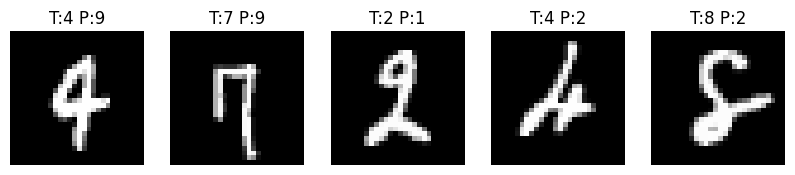

Sequential Model


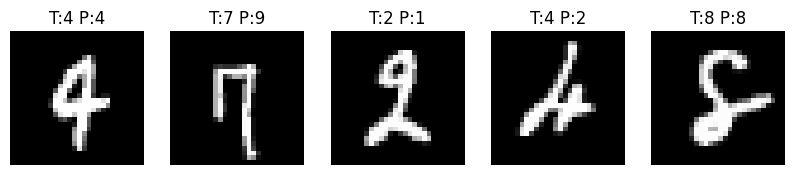

In [94]:
def visualize(model, model2, loader, n=5):
    model.eval()
    x, y = next(iter(loader))
    preds = model(x).argmax(dim=1)
    # x, y = x.to(device), y.to(device)
    preds2 = model2(x).argmax(dim=1)

    plt.figure(figsize=(10, 2))
    i = 0
    j = 0
    
    print("Manual Model")
    indicies = [0]*n
    while True:
        if y[i].item() != preds2[i].item():
            plt.subplot(1, n, j+1)
            plt.imshow(x[i].cpu().squeeze(), cmap='gray')
            plt.title(f"T:{y[i].item()} P:{preds2[i].item()}")
            plt.axis('off')
            indicies[j] = i
            j += 1
            if j > 4:
                break
        i += 1
    plt.show()
    
    print("Sequential Model")
    j = 0
    plt.figure(figsize=(10, 2))
    for i in indicies:
        plt.subplot(1, n, j+1)
        plt.imshow(x[i].cpu().squeeze(), cmap='gray')
        plt.title(f"T:{y[i].item()} P:{preds[i].item()}")
        plt.axis('off')
        j += 1
    plt.show()


test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)
# indicies = visualize(manual_model, test_loader, None, False) # Uncomment this later
visualize(sequential_model, manual_model, test_loader)
# visualize(manual_model, sequential_model, test_loader)

## Assignment
* Load and preprocess CIFAR100 dataset (not CIFAR10)
* Build a feedforward network for it. You can experiment around with number of layers and and neurons in each layer and different activation functions
* You are allowed to use nn.functional. (convolutions _might_ make your accuracy better)

# Bonus Assignment
* Try the solving the "Titanic Survival Prediction" dataset from kaggle